<a href="https://colab.research.google.com/github/MMMMJ-beep/Tumor-Detection/blob/main/Final_Brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()


Saving Te-gl_0015.jpg to Te-gl_0015.jpg
Saving Te-meTr_0001.jpg to Te-meTr_0001.jpg
Saving Te-noTr_0004.jpg to Te-noTr_0004.jpg
Saving Te-piTr_0003.jpg to Te-piTr_0003.jpg


In [2]:
import os  # For directory and file operations
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from sklearn.utils import shuffle  # For shuffling the data

In [3]:
import os
from sklearn.utils import shuffle

# Root folder containing all images (including subfolders)
root_folder = '/content/' # Changed from '/content/start/'

# Prepare lists
all_paths = []
all_labels = []

# Walk through all subfolders
for subdir, dirs, files in os.walk(root_folder):
    for f in files:
        if f.endswith(('.jpg', '.jpeg', '.png')):
            all_paths.append(os.path.join(subdir, f))
            # Extract label from filename: take the part after 'Te-' and before '_'
            label = f.split('-')[1].split('_')[0]
            all_labels.append(label)

# Shuffle the dataset
all_paths, all_labels = shuffle(all_paths, all_labels)

# Optional: use all images as test data
test_paths = all_paths
test_labels = all_labels

print("Test paths:", test_paths)
print("Test labels:", test_labels)

Test paths: ['/content/Te-noTr_0004.jpg', '/content/Te-piTr_0003.jpg', '/content/Te-gl_0015.jpg', '/content/Te-meTr_0001.jpg']
Test labels: ['noTr', 'piTr', 'gl', 'meTr']


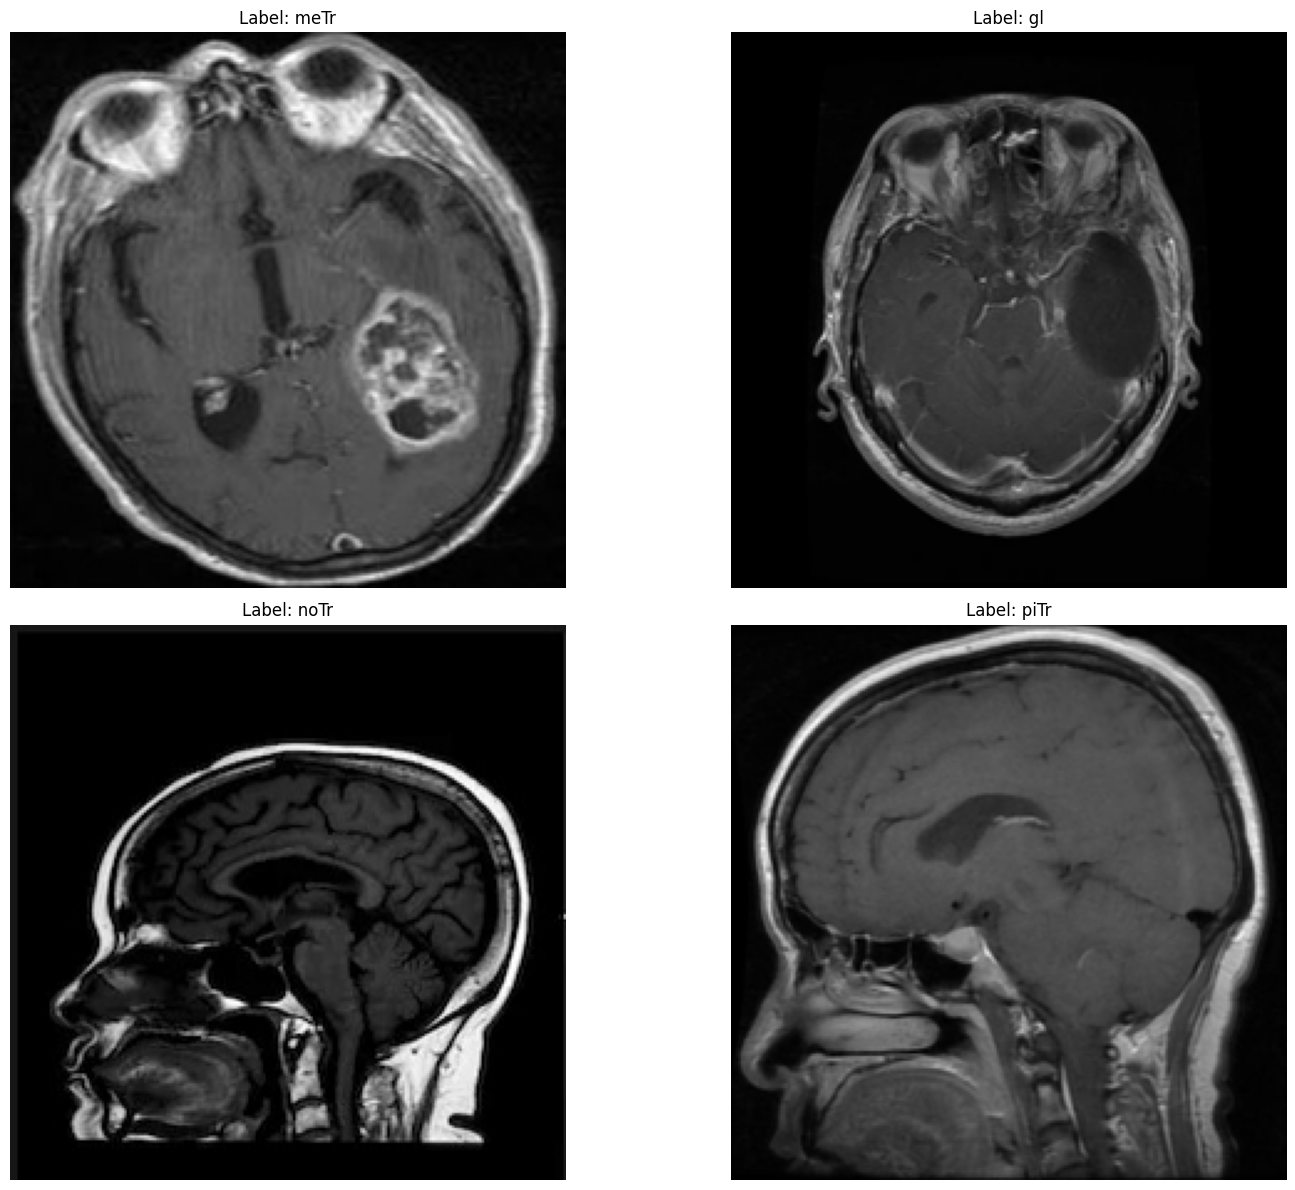

In [4]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import math

# Use your 4 images
paths = test_paths
labels = test_labels

# Select random indices for all available images
random_indices = random.sample(range(len(paths)), len(paths))  # all images

# Determine rows and columns for display
num_images = len(paths)
cols = 2
rows = math.ceil(num_images / cols)

# Create a figure to display images
fig, axes = plt.subplots(rows, cols, figsize=(8 * cols, 6 * rows))

# Ensure axes is always iterable
if num_images == 1:
    axes = [axes]
else:
    axes = axes.ravel()

# Display images
for i, idx in enumerate(random_indices):
    img_path = paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))

    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Label: {labels[idx]}", fontsize=12)

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [5]:
import numpy as np
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import load_img

IMAGE_SIZE = 224  # set target size

# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))    # Random contrast
    image = np.array(image) / 255.0  # Normalize to [0,1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = list(set(labels))  # get unique labels dynamically
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels


In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

IMAGE_SIZE = 224

# Assign test data as training data for now
train_paths = test_paths
train_labels = test_labels

# Base VGG16 model
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

# Build the final model
num_classes = len(set(train_labels))  # number of unique labels

model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Training parameters
batch_size = 2
steps = max(1, int(len(train_paths) / batch_size))
epochs = 5

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 1.3218 - sparse_categorical_accuracy: 0.5000
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 949ms/step - loss: 0.5572 - sparse_categorical_accuracy: 0.8333
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 939ms/step - loss: 0.4203 - sparse_categorical_accuracy: 1.0000
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 965ms/step - loss: 0.1971 - sparse_categorical_accuracy: 1.0000
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 940ms/step - loss: 0.0251 - sparse_categorical_accuracy: 1.0000


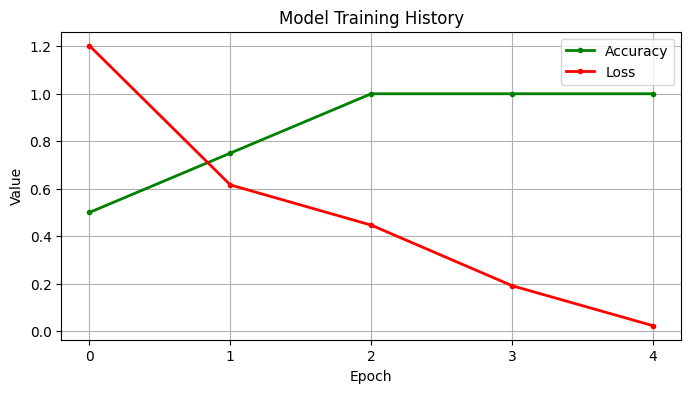

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.xticks([x for x in range(epochs)])
plt.ylabel('Value')
plt.legend(['Accuracy', 'Loss'], loc='upper right')  # simpler legend
plt.show()


In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Load and augment test images
test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels)

# Predict using the trained model
test_predictions = model.predict(test_images)

# Classification report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1), zero_division=0))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       1.0
           2       0.00      0.00      0.00       1.0
           3       0.00      0.00      0.00       1.0

    accuracy                           0.00       4.0
   macro avg       0.00      0.00      0.00       4.0
weighted avg       0.00      0.00      0.00       4.0



Confusion Matrix:
[[0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]]


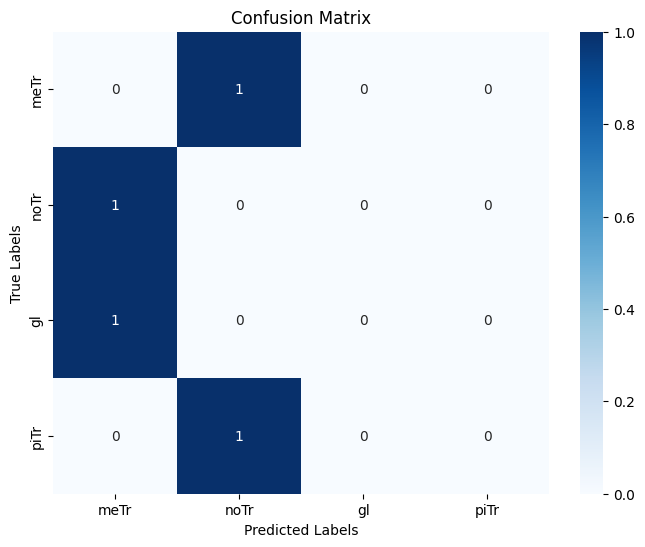

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get unique labels from test_labels
unique_labels = list(set(test_labels))  # or train_labels if you used them

# Compute confusion matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


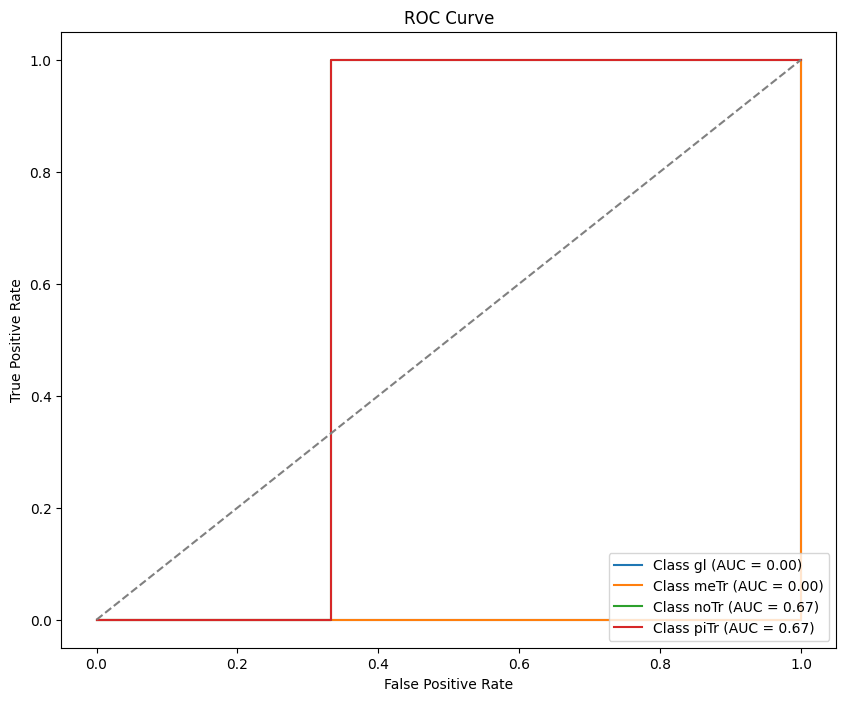

In [10]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

# Get sorted unique labels
unique_labels = sorted(list(set(test_labels)))  # ensures consistent order
num_classes = len(unique_labels)

# Binarize the test labels
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(num_classes))
test_predictions_bin = test_predictions  # predicted probabilities for each class

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {unique_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


In [11]:
# Save the model in the recommended Keras format
model.save('my_brain_tumor_model.keras')
print("Model saved as my_brain_tumor_model.keras")


Model saved as my_brain_tumor_model.keras


In [12]:
from tensorflow.keras.models import load_model
loaded_model = load_model('my_brain_tumor_model.keras')


In [13]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('my_brain_tumor_model.keras') # Changed .h5 to .keras
print("Model loaded successfully!")

Model loaded successfully!


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array

# Dynamic class labels based on your dataset
class_labels = sorted(list(set(test_labels)))  # e.g., ['glioma', 'meningioma', 'notumor', 'pituitary']

def detect_and_display(img_path, model, image_size=224):
    """
    Detect tumor and display results with confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine class
        if class_labels[predicted_class_index].lower() == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score*100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


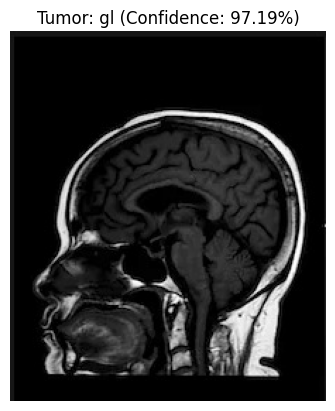

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


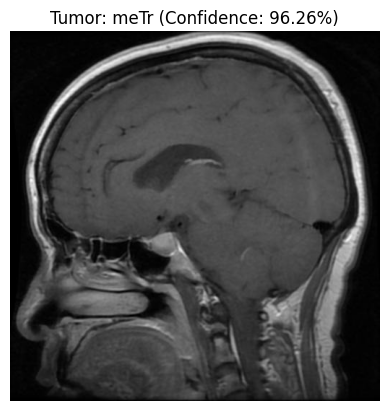

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


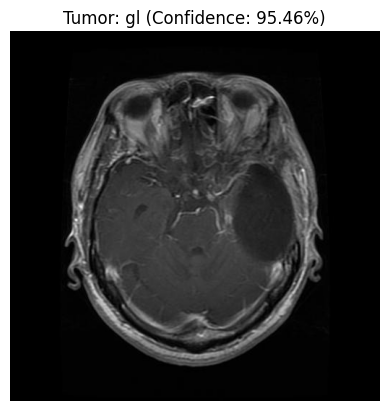

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


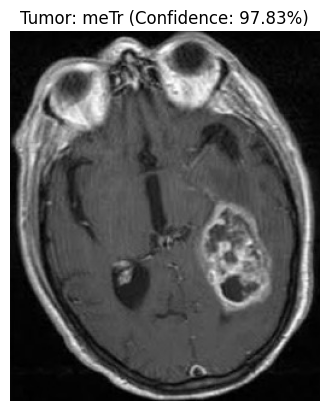

In [15]:
for img_path in test_paths:
    detect_and_display(img_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


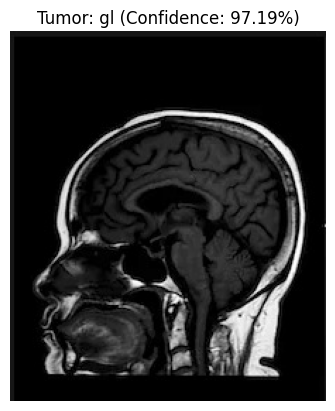

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


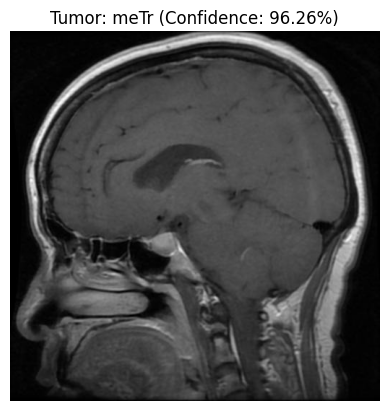

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


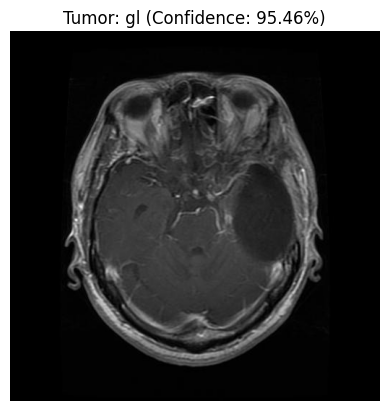

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step


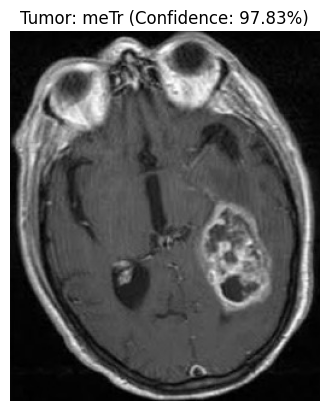

In [16]:
# Loop through all 4 images and display predictions
for img_path in test_paths:
    detect_and_display(img_path, model)


In [17]:
# Correct path for your uploaded image
image_path = '/content/start/some pics/Te-noTr_0004.jpg'

# Call the function
detect_and_display(image_path, model)


Error processing the image: [Errno 2] No such file or directory: '/content/start/some pics/Te-noTr_0004.jpg'


In [18]:
# Correct path for your image in your uploaded folder
image_path = '/content/start/some pics/Te-piTr_0003.jpg'

# Call the function
detect_and_display(image_path, model)


Error processing the image: [Errno 2] No such file or directory: '/content/start/some pics/Te-piTr_0003.jpg'


In [19]:
# Correct path for your image
image_path = '/content/start/some pics/Te-gl_0015.jpg'

# Display prediction
detect_and_display(image_path, model)


Error processing the image: [Errno 2] No such file or directory: '/content/start/some pics/Te-gl_0015.jpg'


Error processing the image: [Errno 2] No such file or directory: '/content/start/some pics/Te-gl_0015.jpg'
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step


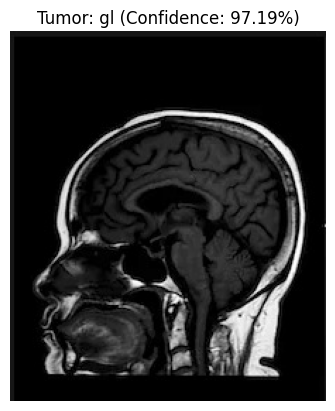

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


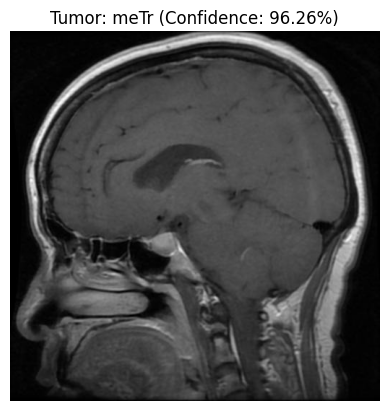

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


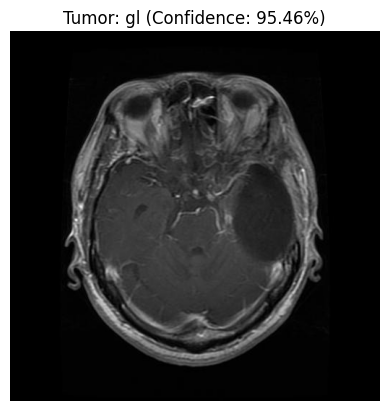

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


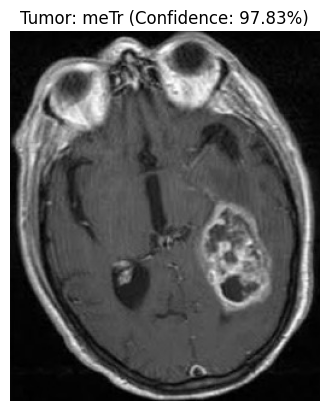

In [20]:
# Predict one image
image_path = '/content/start/some pics/Te-gl_0015.jpg'
detect_and_display(image_path, model)

# Or predict all 4 images in a loop
for img_path in test_paths:
    detect_and_display(img_path, model)


In [21]:
# Mapping short codes to full tumor names
label_map = {
    'gl': 'glioma',
    'meTr': 'meningioma',
    'noTr': 'no tumor',
    'piTr': 'pituitary'
}

# Update test_labels with full names
test_labels = [label_map.get(label, label) for label in test_labels]

# Also update class_labels used in detect function
class_labels = sorted(list(set(test_labels)))  # now contains full names

print("Updated test labels:", test_labels)
print("Class labels:", class_labels)


Updated test labels: ['no tumor', 'pituitary', 'glioma', 'meningioma']
Class labels: ['glioma', 'meningioma', 'no tumor', 'pituitary']


Upload one of your 4 images to predict tumor type:


Saving Te-piTr_0003.jpg to Te-piTr_0003 (1).jpg
Image uploaded: /content/Te-piTr_0003 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step


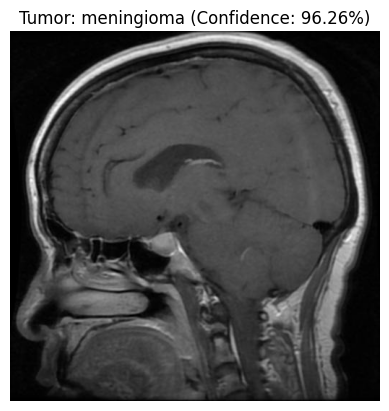

In [23]:
from google.colab import files
import os

# Ask user to upload an image
print("Upload one of your 4 images to predict tumor type:")
uploaded = files.upload()  # This will open a file picker in Colab

# Get the uploaded file path
for filename in uploaded.keys():
    image_path = os.path.join('/content', filename)
    print(f"Image uploaded: {image_path}")

    # Call your prediction function
    detect_and_display(image_path, model)
